# DATA 200 – Applied Statistical Analysis
## Week 5: Statistical Analysis and Validation
**Team Fintech** | Saugat Ojha · Rakesh Kumar Sah · Naitik Shrestha

---
## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', font_scale=1.05)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (12, 5)

BLUE = '#2E86AB'
RED  = '#E84855'

---
## 2. Load and Prepare Data

In [2]:
df = pd.read_csv(r'C:\Users\admin\Desktop\project-team-x\bank.csv')
df['deposit_bin'] = (df['deposit'] == 'yes').astype(int)

df_encoded = df.copy()
le = LabelEncoder()
cat_cols = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'poutcome']

for col in cat_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

df_encoded.drop(columns=['deposit'], inplace=True)

features = [c for c in df_encoded.columns if c != 'deposit_bin']
X = df_encoded[features]
y = df_encoded['deposit_bin']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lr_rfe = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(estimator=lr_rfe, n_features_to_select=8)
rfe.fit(X_scaled, y)

selected_features = [f for f, s in zip(features, rfe.support_) if s]
print('Selected features:', selected_features)

X_selected = df_encoded[selected_features]
X_scaled_selected = scaler.fit_transform(X_selected)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Train size: {X_train.shape[0]} | Test size: {X_test.shape[0]}')

Selected features: ['education', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous']
Train size: 8929 | Test size: 2233


---
## 3. Descriptive Statistics by Group

In [3]:
num_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

desc_yes = df[df['deposit'] == 'yes'][num_cols].describe().round(2)
desc_no  = df[df['deposit'] == 'no'][num_cols].describe().round(2)

print('Subscribed (yes):')
print(desc_yes)
print('\nNot Subscribed (no):')
print(desc_no)

Subscribed (yes):
           age   balance  duration  campaign    pdays  previous
count  5289.00   5289.00   5289.00   5289.00  5289.00   5289.00
mean     41.67   1804.27    537.29      2.14    68.70      1.17
std      13.50   3501.10    392.53      1.92   118.82      2.55
min      18.00  -3058.00      8.00      1.00    -1.00      0.00
25%      31.00    210.00    244.00      1.00    -1.00      0.00
50%      38.00    733.00    426.00      2.00    -1.00      0.00
75%      50.00   2159.00    725.00      3.00    98.00      1.00
max      95.00  81204.00   3881.00     32.00   854.00     58.00

Not Subscribed (no):
           age   balance  duration  campaign    pdays  previous
count  5873.00   5873.00   5873.00   5873.00  5873.00   5873.00
mean     40.84   1280.23    223.13      2.84    35.69      0.53
std      10.26   2933.41    208.58      3.24    96.18      1.98
min      18.00  -6847.00      2.00      1.00    -1.00      0.00
25%      33.00     64.00     94.00      1.00    -1.00      0.00


---
## 4. Inferential Statistics – Hypothesis Testing

### H1: Call duration is positively associated with subscription

In [4]:
dur_yes = df[df['deposit'] == 'yes']['duration']
dur_no  = df[df['deposit'] == 'no']['duration']

t_stat, p_val = stats.ttest_ind(dur_yes, dur_no)
print(f'H1 – Duration T-Test')
print(f'  Mean (subscribed)     : {dur_yes.mean():.2f} seconds')
print(f'  Mean (not subscribed) : {dur_no.mean():.2f} seconds')
print(f'  t-statistic           : {t_stat:.4f}')
print(f'  p-value               : {p_val:.6f}')
print(f'  Result                : {"Reject H0 - Significant" if p_val < 0.05 else "Fail to Reject H0"}')

H1 – Duration T-Test
  Mean (subscribed)     : 537.29 seconds
  Mean (not subscribed) : 223.13 seconds
  t-statistic           : 53.5180
  p-value               : 0.000000
  Result                : Reject H0 - Significant


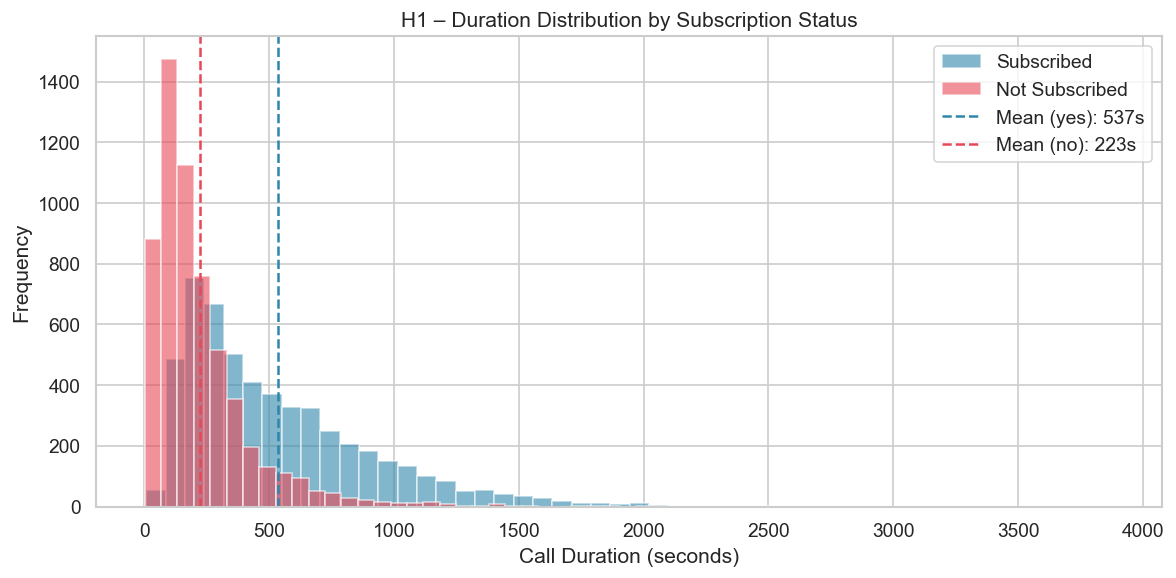

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(dur_yes, bins=50, alpha=0.6, color=BLUE, label='Subscribed', edgecolor='white')
ax.hist(dur_no,  bins=50, alpha=0.6, color=RED,  label='Not Subscribed', edgecolor='white')
ax.axvline(dur_yes.mean(), color=BLUE, linestyle='--', linewidth=1.5, label=f'Mean (yes): {dur_yes.mean():.0f}s')
ax.axvline(dur_no.mean(),  color=RED,  linestyle='--', linewidth=1.5, label=f'Mean (no): {dur_no.mean():.0f}s')
ax.set_xlabel('Call Duration (seconds)')
ax.set_ylabel('Frequency')
ax.set_title('H1 – Duration Distribution by Subscription Status')
ax.legend()
plt.tight_layout()
plt.show()

### H2: Previous campaign success increases subscription likelihood

In [6]:
contingency = pd.crosstab(df['poutcome'], df['deposit'])
chi2_stat, p_val_h2, dof, expected = stats.chi2_contingency(contingency)

print(f'H2 – Poutcome Chi-Square Test')
print(f'  Chi2 statistic : {chi2_stat:.4f}')
print(f'  Degrees of freedom : {dof}')
print(f'  p-value        : {p_val_h2:.6f}')
print(f'  Result         : {"Reject H0 - Significant" if p_val_h2 < 0.05 else "Fail to Reject H0"}')
print(f'\nCross-tabulation:')
print(contingency)

H2 – Poutcome Chi-Square Test
  Chi2 statistic : 1004.6358
  Degrees of freedom : 3
  p-value        : 0.000000
  Result         : Reject H0 - Significant

Cross-tabulation:
deposit     no   yes
poutcome            
failure    610   618
other      230   307
success     93   978
unknown   4940  3386


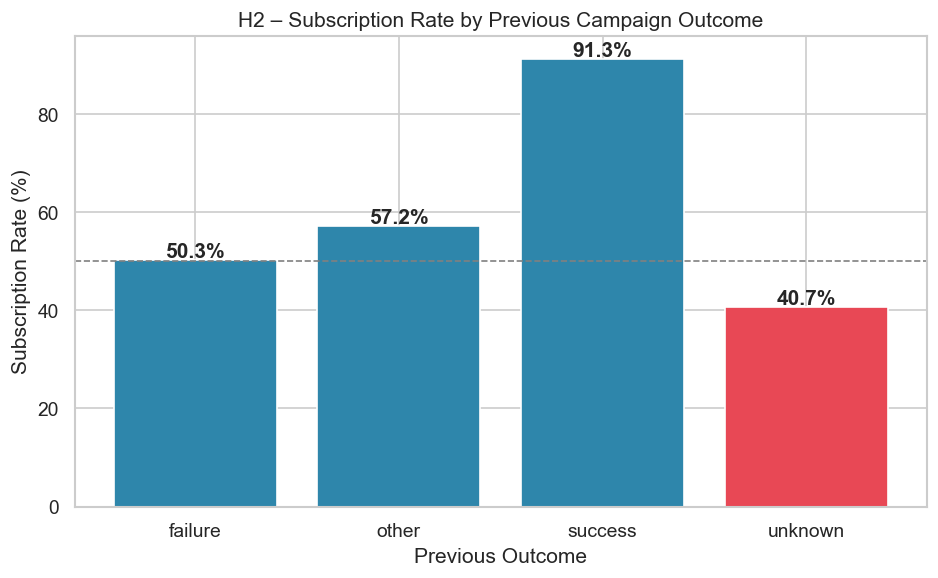

In [7]:
poutcome_rate = df.groupby('poutcome')['deposit'].apply(lambda x: (x == 'yes').mean() * 100)

fig, ax = plt.subplots(figsize=(8, 5))
colors = [BLUE if v >= 50 else RED for v in poutcome_rate.values]
bars = ax.bar(poutcome_rate.index, poutcome_rate.values, color=colors, edgecolor='white')
for bar, val in zip(bars, poutcome_rate.values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.5,
            f'{val:.1f}%', ha='center', fontweight='bold')
ax.set_xlabel('Previous Outcome')
ax.set_ylabel('Subscription Rate (%)')
ax.set_title('H2 – Subscription Rate by Previous Campaign Outcome')
ax.axhline(50, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

### H3: Higher account balance is associated with subscription

In [8]:
bal_yes = df[df['deposit'] == 'yes']['balance']
bal_no  = df[df['deposit'] == 'no']['balance']

t_stat_h3, p_val_h3 = stats.ttest_ind(bal_yes, bal_no)
print(f'H3 – Balance T-Test')
print(f'  Mean (subscribed)     : {bal_yes.mean():.2f}')
print(f'  Mean (not subscribed) : {bal_no.mean():.2f}')
print(f'  t-statistic           : {t_stat_h3:.4f}')
print(f'  p-value               : {p_val_h3:.6f}')
print(f'  Result                : {"Reject H0 - Significant" if p_val_h3 < 0.05 else "Fail to Reject H0"}')

H3 – Balance T-Test
  Mean (subscribed)     : 1804.27
  Mean (not subscribed) : 1280.23
  t-statistic           : 8.5988
  p-value               : 0.000000
  Result                : Reject H0 - Significant


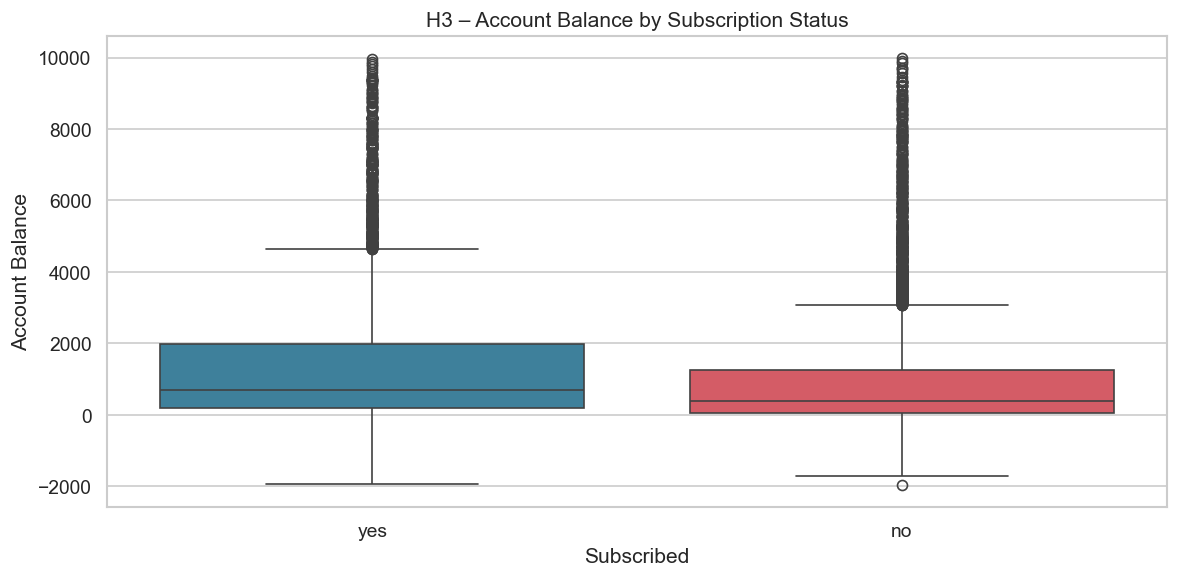

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df[df['balance'].between(-2000, 10000)],
            x='deposit', y='balance',
            palette={'yes': BLUE, 'no': RED},
            order=['yes', 'no'], ax=ax)
ax.set_title('H3 – Account Balance by Subscription Status')
ax.set_xlabel('Subscribed')
ax.set_ylabel('Account Balance')
plt.tight_layout()
plt.show()

### H4: More campaign contacts is negatively associated with subscription

In [10]:
camp_yes = df[df['deposit'] == 'yes']['campaign']
camp_no  = df[df['deposit'] == 'no']['campaign']

t_stat_h4, p_val_h4 = stats.ttest_ind(camp_yes, camp_no)
print(f'H4 – Campaign Contacts T-Test')
print(f'  Mean (subscribed)     : {camp_yes.mean():.2f} contacts')
print(f'  Mean (not subscribed) : {camp_no.mean():.2f} contacts')
print(f'  t-statistic           : {t_stat_h4:.4f}')
print(f'  p-value               : {p_val_h4:.6f}')
print(f'  Result                : {"Reject H0 - Significant" if p_val_h4 < 0.05 else "Fail to Reject H0"}')

H4 – Campaign Contacts T-Test
  Mean (subscribed)     : 2.14 contacts
  Mean (not subscribed) : 2.84 contacts
  t-statistic           : -13.6429
  p-value               : 0.000000
  Result                : Reject H0 - Significant


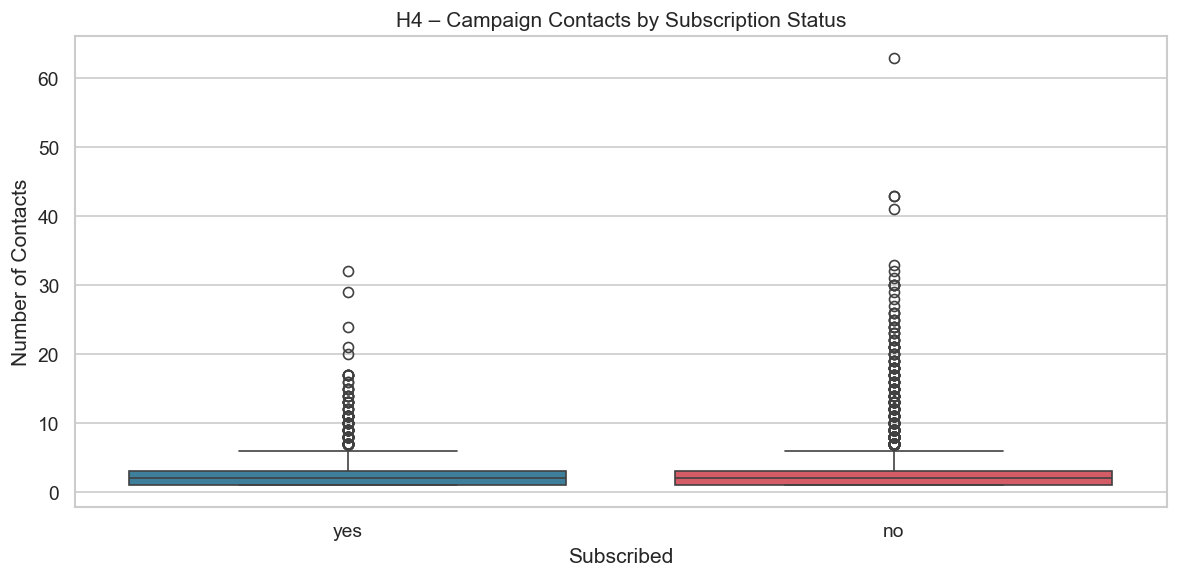

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x='deposit', y='campaign',
            palette={'yes': BLUE, 'no': RED},
            order=['yes', 'no'], ax=ax)
ax.set_title('H4 – Campaign Contacts by Subscription Status')
ax.set_xlabel('Subscribed')
ax.set_ylabel('Number of Contacts')
plt.tight_layout()
plt.show()

---
## 5. Hypothesis Testing Summary

In [12]:
hyp_results = pd.DataFrame({
    'Hypothesis': ['H1', 'H2', 'H3', 'H4'],
    'Test Used': ['Independent T-Test', 'Chi-Square Test', 'Independent T-Test', 'Independent T-Test'],
    'p-value': [
        round(p_val, 6),
        round(p_val_h2, 6),
        round(p_val_h3, 6),
        round(p_val_h4, 6)
    ],
    'Decision': [
        'Reject H0' if p_val < 0.05 else 'Fail to Reject H0',
        'Reject H0' if p_val_h2 < 0.05 else 'Fail to Reject H0',
        'Reject H0' if p_val_h3 < 0.05 else 'Fail to Reject H0',
        'Reject H0' if p_val_h4 < 0.05 else 'Fail to Reject H0'
    ],
    'Conclusion': [
        'Duration significantly affects subscription',
        'Previous outcome significantly affects subscription',
        'Balance significantly affects subscription',
        'Campaign contacts significantly affect subscription'
    ]
})

hyp_results

,Hypothesis,Test Used,p-value,Decision,Conclusion
0,H1,Independent T-Test,0.0,Reject H0,Duration significantly affects subscription
1,H2,Chi-Square Test,0.0,Reject H0,Previous outcome significantly affects subscri...
2,H3,Independent T-Test,0.0,Reject H0,Balance significantly affects subscription
3,H4,Independent T-Test,0.0,Reject H0,Campaign contacts significantly affect subscri...


---
## 6. Logistic Regression – Full Model

In [13]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_pred       = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

acc     = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy : {acc*100:.2f}%')
print(f'ROC-AUC  : {roc_auc:.4f}')
print()
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

Accuracy : 79.22%
ROC-AUC  : 0.8701

Classification Report:
              precision    recall  f1-score   support

          No       0.79      0.82      0.81      1175
         Yes       0.79      0.76      0.78      1058

    accuracy                           0.79      2233
   macro avg       0.79      0.79      0.79      2233
weighted avg       0.79      0.79      0.79      2233



---
## 7. Model Diagnostics

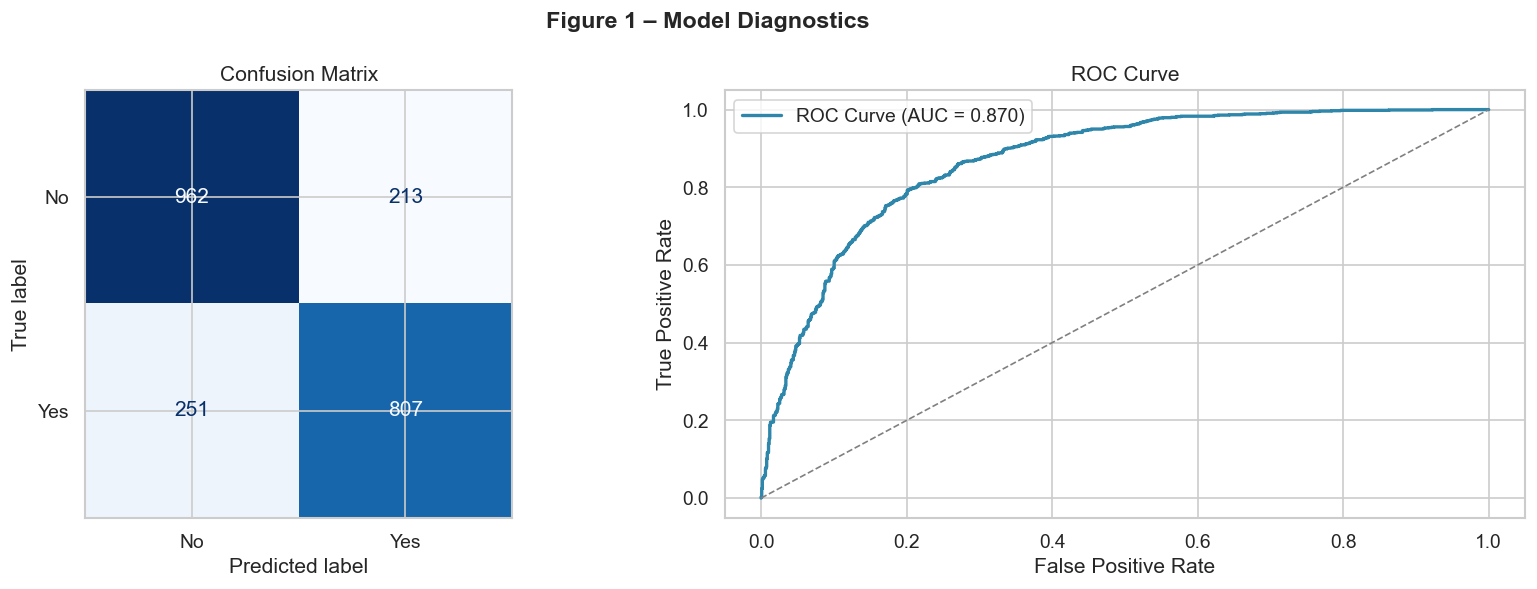

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Figure 1 – Model Diagnostics', fontsize=14, fontweight='bold')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(ax=axes[0], colorbar=False, cmap='Blues')
axes[0].set_title('Confusion Matrix')

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color=BLUE, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 8. Cross-Validation

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_scaled_selected, y, cv=cv, scoring='accuracy')
cv_auc    = cross_val_score(model, X_scaled_selected, y, cv=cv, scoring='roc_auc')

print('5-Fold Cross-Validation Results:')
print(f'  Accuracy  : {cv_scores.mean()*100:.2f}% (+/- {cv_scores.std()*100:.2f}%)')
print(f'  ROC-AUC   : {cv_auc.mean():.4f} (+/- {cv_auc.std():.4f})')
print(f'  Fold Scores: {[round(s*100,2) for s in cv_scores]}')

5-Fold Cross-Validation Results:
  Accuracy  : 79.02% (+/- 0.86%)
  ROC-AUC   : 0.8657 (+/- 0.0062)
  Fold Scores: [np.float64(79.04), np.float64(80.65), np.float64(78.54), np.float64(78.63), np.float64(78.23)]


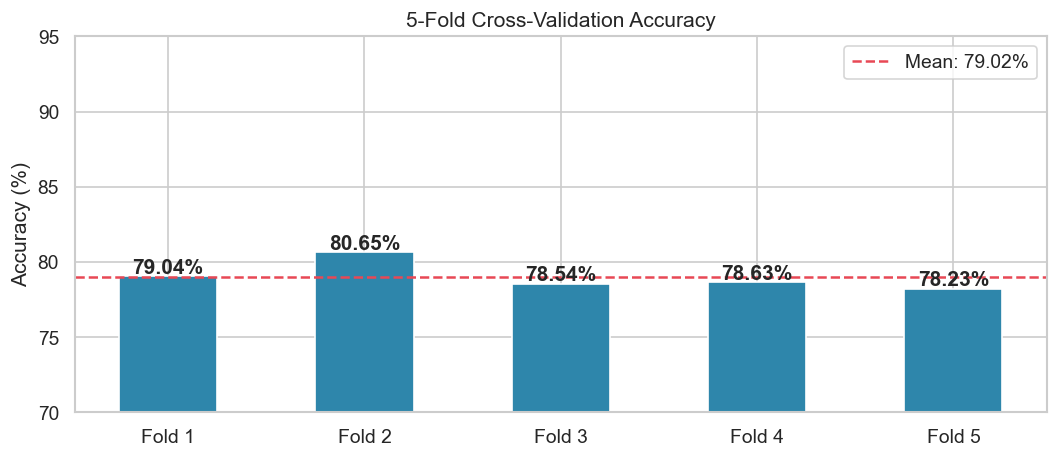

In [16]:
fig, ax = plt.subplots(figsize=(9, 4))
folds = [f'Fold {i+1}' for i in range(5)]
bars = ax.bar(folds, cv_scores * 100, color=BLUE, edgecolor='white', width=0.5)
for bar, val in zip(bars, cv_scores):
    ax.text(bar.get_x() + bar.get_width()/2, val*100 + 0.2,
            f'{val*100:.2f}%', ha='center', fontweight='bold')
ax.axhline(cv_scores.mean()*100, color=RED, linestyle='--', linewidth=1.5,
           label=f'Mean: {cv_scores.mean()*100:.2f}%')
ax.set_ylabel('Accuracy (%)')
ax.set_title('5-Fold Cross-Validation Accuracy')
ax.set_ylim(70, 95)
ax.legend()
plt.tight_layout()
plt.show()

---
## 9. Feature Coefficients and Odds Ratios

In [17]:
coef_df = pd.DataFrame({
    'feature': selected_features,
    'coefficient': model.coef_[0].round(4),
    'odds_ratio': np.exp(model.coef_[0]).round(4)
}).sort_values('coefficient', ascending=False)

print('Feature Coefficients and Odds Ratios:')
print(coef_df.to_string(index=False))

Feature Coefficients and Odds Ratios:
  feature  coefficient  odds_ratio
 duration       1.7230      5.6011
 previous       0.2416      1.2733
    pdays       0.2262      1.2539
education       0.1781      1.1950
     loan      -0.2823      0.7540
 campaign      -0.3920      0.6757
  contact      -0.5031      0.6046
  housing      -0.5294      0.5890


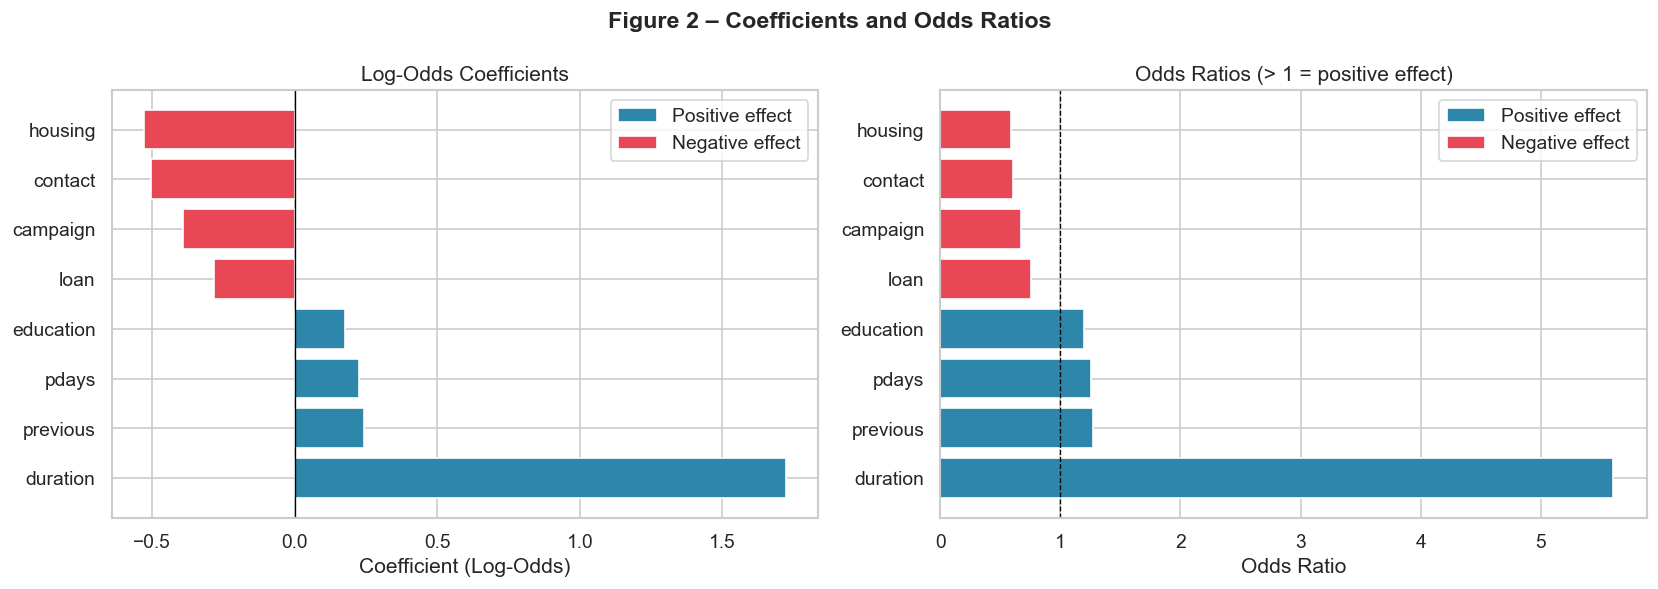

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Figure 2 – Coefficients and Odds Ratios', fontsize=14, fontweight='bold')

colors = [BLUE if c > 0 else RED for c in coef_df['coefficient']]
axes[0].barh(coef_df['feature'], coef_df['coefficient'], color=colors, edgecolor='white')
axes[0].axvline(0, color='black', linewidth=0.8)
axes[0].set_xlabel('Coefficient (Log-Odds)')
axes[0].set_title('Log-Odds Coefficients')
legend_elements = [
    Patch(facecolor=BLUE, label='Positive effect'),
    Patch(facecolor=RED,  label='Negative effect')
]
axes[0].legend(handles=legend_elements)

axes[1].barh(coef_df['feature'], coef_df['odds_ratio'], color=colors, edgecolor='white')
axes[1].axvline(1, color='black', linewidth=0.8, linestyle='--')
axes[1].set_xlabel('Odds Ratio')
axes[1].set_title('Odds Ratios (> 1 = positive effect)')
axes[1].legend(handles=legend_elements)

plt.tight_layout()
plt.show()

---
## 10. Week 5 Summary

In [19]:
print(f"""
Week 5 Summary
=============================================================
Hypothesis Testing Results:
  H1 (Duration)          : Reject H0  | p = {p_val:.6f}
  H2 (Prev. Outcome)     : Reject H0  | p = {p_val_h2:.6f}
  H3 (Balance)           : Reject H0  | p = {p_val_h3:.6f}
  H4 (Campaign Contacts) : Reject H0  | p = {p_val_h4:.6f}

All 4 hypotheses were statistically significant at alpha = 0.05.

Model Performance:
  Accuracy  (Test Set)   : {acc*100:.2f}%
  ROC-AUC   (Test Set)   : {roc_auc:.4f}
  CV Accuracy (5-Fold)   : {cv_scores.mean()*100:.2f}% +/- {cv_scores.std()*100:.2f}%
  CV ROC-AUC (5-Fold)    : {cv_auc.mean():.4f} +/- {cv_auc.std():.4f}

Next Steps (Week 6):
  - Finalize insights and compile project report
  - Present statistical analysis results
=============================================================
""")


Week 5 Summary
Hypothesis Testing Results:
  H1 (Duration)          : Reject H0  | p = 0.000000
  H2 (Prev. Outcome)     : Reject H0  | p = 0.000000
  H3 (Balance)           : Reject H0  | p = 0.000000
  H4 (Campaign Contacts) : Reject H0  | p = 0.000000

All 4 hypotheses were statistically significant at alpha = 0.05.

Model Performance:
  Accuracy  (Test Set)   : 79.22%
  ROC-AUC   (Test Set)   : 0.8701
  CV Accuracy (5-Fold)   : 79.02% +/- 0.86%
  CV ROC-AUC (5-Fold)    : 0.8657 +/- 0.0062

Next Steps (Week 6):
  - Finalize insights and compile project report
  - Present statistical analysis results

